In [1]:
import pandas as pd
import numpy as np
import panel as pn
from matplotlib.figure import Figure

pn.extension()

# Load Data

In [2]:
df = (
    pd.read_csv("timing.csv", header=None, names=['module', 'len_Q', 'len_T', 'n_iter', 'time'])
    .pipe(
        lambda x: x.assign(Q_p=np.log2(x.len_Q).astype(np.int64))
    )
    .pipe(
        lambda x: x.assign(T_p=np.log2(x.len_T).astype(np.int64))
    )
    .groupby(['module', 'len_Q']).filter(lambda x: len(x) >= 2)
)
df

,module,len_Q,len_T,n_iter,time,Q_p,T_p
0,sdp.pyfftw_sdp,64,64,3,0.000069,6,6
1,sdp.pyfftw_sdp,64,128,3,0.000080,6,7
2,sdp.pyfftw_sdp,64,256,3,0.000106,6,8
3,sdp.pyfftw_sdp,64,512,3,0.000146,6,9
4,sdp.pyfftw_sdp,64,1024,3,0.000215,6,10
...,...,...,...,...,...,...,...
873,sdp.scipy_oaconvolve_sdp,16777216,33554432,3,1.788871,24,25
874,sdp.scipy_oaconvolve_sdp,16777216,67108864,3,2.994278,24,26
875,sdp.scipy_oaconvolve_sdp,16777216,134217728,3,6.983685,24,27
876,sdp.scipy_oaconvolve_sdp,33554432,33554432,3,2.444229,25,25


# Create Interactive Plot(s)

In [3]:
GLOBAL_FIG = Figure()
GLOBAL_FIG.set_size_inches(12, 6)

In [4]:
def get_fig(mod_vals, Q_len_vals):
    fig = GLOBAL_FIG
    fig.clf()
    ax = fig.subplots((1))

    if len(mod_vals) > 0 and len(Q_len_vals) > 0:
        for Q_len in Q_len_vals:
            for mod in mod_vals:
                plot_df = (
                    df.query('module == @mod')
                    .query('len_Q == @Q_len')
                    .loc[:, ['T_p', 'time']]
                )
                line, = ax.plot(plot_df.T_p, plot_df.time)

    return fig

Column
    [0] CheckButtonGroup(options=['sdp.pyfftw_sdp', ...], value=['sdp.pyfftw_sdp'])
    [1] Row
        [0] CheckBoxGroup(options=[64, 128, 256, ...], value=[64])
        [1] Matplotlib(Figure, dpi=96, tight=True)
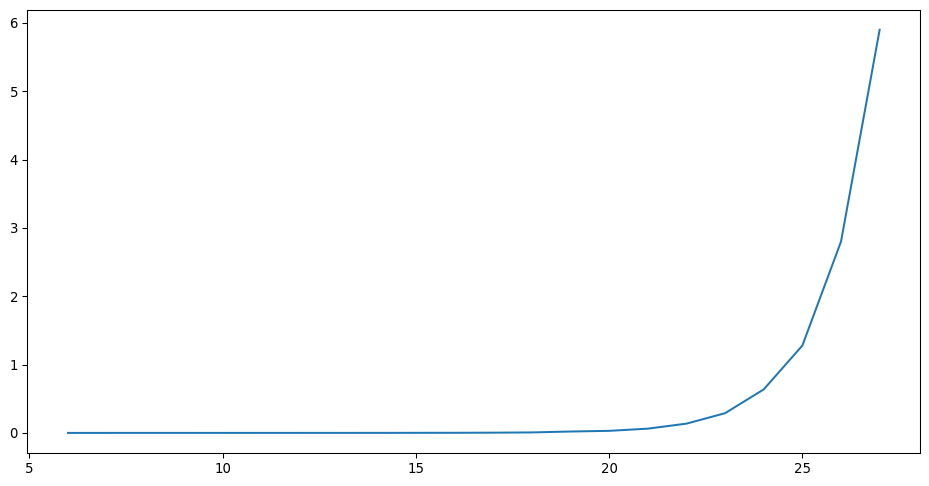

In [5]:
# Select default widget values
mod_vals = df.module.unique().tolist()[:1]
Q_len_vals = [df.len_Q.min().item()]

# Create plot
plot = pn.pane.Matplotlib(get_fig(mod_vals, Q_len_vals), dpi=96, tight=True)

# Create widgets with default values
mod_widget = pn.widgets.CheckButtonGroup(value=mod_vals, options=df.module.unique().tolist())
Q_len_widget = pn.widgets.CheckBoxGroup(value=Q_len_vals, options=df.len_Q.unique().tolist())

# Create function to update plot
@pn.depends(mod_widget, Q_len_widget, watch=True)
def update(mod_vals, Q_len_vals):
    get_fig(mod_vals, Q_len_vals)
    plot.param.trigger("object")

pn.Column(mod_widget, pn.Row(Q_len_widget, plot))